## Imports

In [1]:

import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from graphs import plot_correlation_matrix

import torch
from torchvision import datasets, transforms

#quanutm lib
import pennylane as qml
from pennylane import numpy as np

from pennylane.optimize import AdamOptimizer

import torch
from torchvision import datasets, transforms

C:\Users\tomut\anaconda3\envs\qhack2022\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\tomut\anaconda3\envs\qhack2022\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import sys
sys.path.append("..") # Adds higher directory to python modules path

from qencode.initialize import setAB_amplitude, setAux, setEnt
from qencode.encoders import e3_enhance
from qencode.training_circuits import swap_t
from qencode.qubits_arrangement import QubitsArrangement

from qencode.utils.mnist import get_dataset

## Data

In [3]:
df=pd.read_csv("cancer.csv", nrows=500)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
diagnosis=[]
for d in df.diagnosis:
    if d=="M":
        diagnosis.append(1.0)
    else:
        diagnosis.append(0.0)
df["diagnosis"]=diagnosis

In [5]:
print('Benign: ', df['diagnosis'].value_counts()[0])
print('Malign: ', df['diagnosis'].value_counts()[1])

Benign:  305
Malign:  195


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       500 non-null    int64  
 1   diagnosis                500 non-null    float64
 2   radius_mean              500 non-null    float64
 3   texture_mean             500 non-null    float64
 4   perimeter_mean           500 non-null    float64
 5   area_mean                500 non-null    float64
 6   smoothness_mean          500 non-null    float64
 7   compactness_mean         500 non-null    float64
 8   concavity_mean           500 non-null    float64
 9   concave points_mean      500 non-null    float64
 10  symmetry_mean            500 non-null    float64
 11  fractal_dimension_mean   500 non-null    float64
 12  radius_se                500 non-null    float64
 13  texture_se               500 non-null    float64
 14  perimeter_se             5

In [7]:
df.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,0.0
mean,3.263049e+07,0.390000,14.224206,19.086320,92.606620,662.844800,0.095978,0.103948,0.089941,0.049446,...,25.508500,108.258320,896.003200,0.131972,0.256324,0.276420,0.115980,0.292212,0.083778,NaN
std,1.326933e+08,0.488238,3.476809,4.164842,23.983476,349.357241,0.013666,0.053096,0.080259,0.038875,...,6.063133,33.312706,571.074422,0.022739,0.159147,0.209012,0.065896,0.063366,0.018108,NaN
min,8.670000e+03,0.000000,6.981000,9.710000,43.790000,143.500000,0.062510,0.019380,0.000000,0.000000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.667040e+05,0.000000,11.807500,16.070000,75.995000,430.550000,0.085992,0.063622,0.028885,0.020245,...,21.017500,84.567500,522.600000,0.116200,0.145925,0.114475,0.063302,0.251700,0.071270,NaN
50%,9.014320e+05,0.000000,13.435000,18.680000,86.735000,556.150000,0.095825,0.091280,0.064315,0.033870,...,25.240000,97.980000,691.750000,0.131250,0.214850,0.231400,0.100650,0.283100,0.079900,NaN
75%,8.910808e+06,1.000000,16.115000,21.562500,106.225000,800.775000,0.105100,0.130500,0.132150,0.074928,...,29.350000,127.150000,1150.750000,0.146000,0.343525,0.389450,0.166850,0.320050,0.092065,NaN
max,9.113205e+08,1.000000,28.110000,39.280000,188.500000,2501.000000,0.144700,0.345400,0.426800,0.201200,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


In [8]:
#Data seams pretty clean  without any nan value 

In [9]:
## engineering two new features to have 32 feutures that can be encoded om 5 qubits.
over_average = []
under_average = []

mean = {}
std = {}
for col in df:
     if col not in ["id","diagnosis" ]:
        mean[col]=df[col].mean()
        std[col]=df[col].std()

for index,row in df.iterrows():
    o_average=0
    u_average=0
    for col in df:
        if col not in ["id","diagnosis" ]:
            if  row[col]> mean[col]+2* std[col]:
                o_average = o_average + 1
            if  row[col]< mean[col]+2* std[col]:
                u_average= u_average + 1
                
    over_average.append(o_average)
    under_average.append(u_average)

df["over_average"] = over_average
df["under_average"] = under_average

df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,over_average,under_average
0,842302,1.0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN,13,17
1,842517,1.0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN,0,30
2,84300903,1.0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN,1,29
3,84348301,1.0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN,12,18
4,84358402,1.0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN,0,30


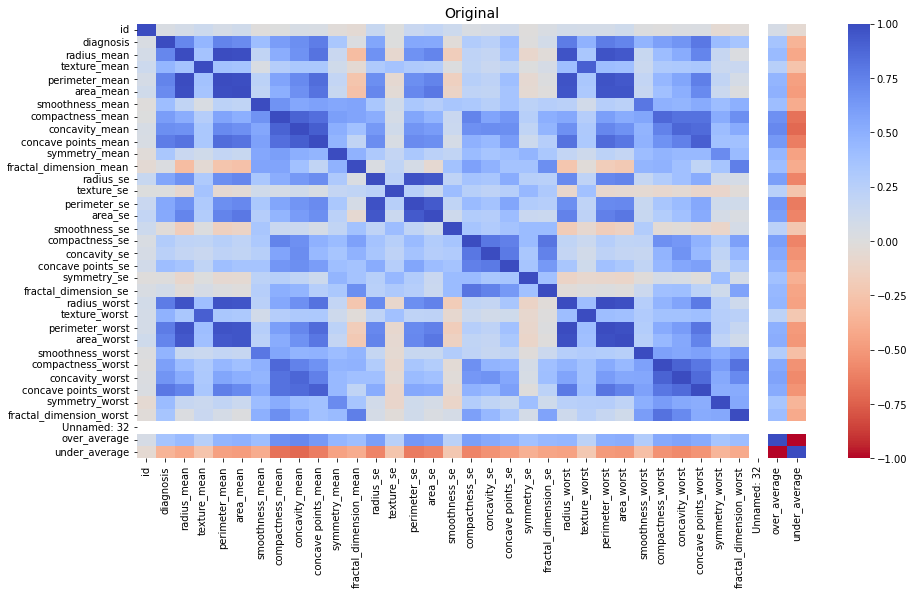

In [10]:
plot_correlation_matrix(df, "Original")

In [11]:
df = df.sample(frac=1)
fraud_df = df.loc[df['diagnosis'] == 0][:195]
non_fraud_df = df.loc[df['diagnosis'] == 1]
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
sub_sample_df = normal_distributed_df.sample(frac=1, random_state=42)

sub_sample_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,over_average,under_average
173,871641,0.0,11.08,14.71,70.21,372.7,0.10060,0.05743,0.02363,0.02583,...,396.5,0.1216,0.0824,0.03938,0.04306,0.1902,0.07313,NaN,1,29
288,8913049,0.0,11.26,19.96,73.72,394.1,0.08020,0.11810,0.09274,0.05588,...,437.6,0.1028,0.1843,0.15460,0.09314,0.2955,0.07009,NaN,4,26
238,883270,0.0,14.22,27.85,92.55,623.9,0.08223,0.10390,0.11030,0.04408,...,764.0,0.1081,0.2426,0.30640,0.08219,0.1890,0.07796,NaN,3,27
323,895100,1.0,20.34,21.51,135.90,1264.0,0.11700,0.18750,0.25650,0.15040,...,1938.0,0.1592,0.4492,0.53440,0.26850,0.5558,0.10240,NaN,5,25
2,84300903,1.0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,1709.0,0.1444,0.4245,0.45040,0.24300,0.3613,0.08758,NaN,1,29


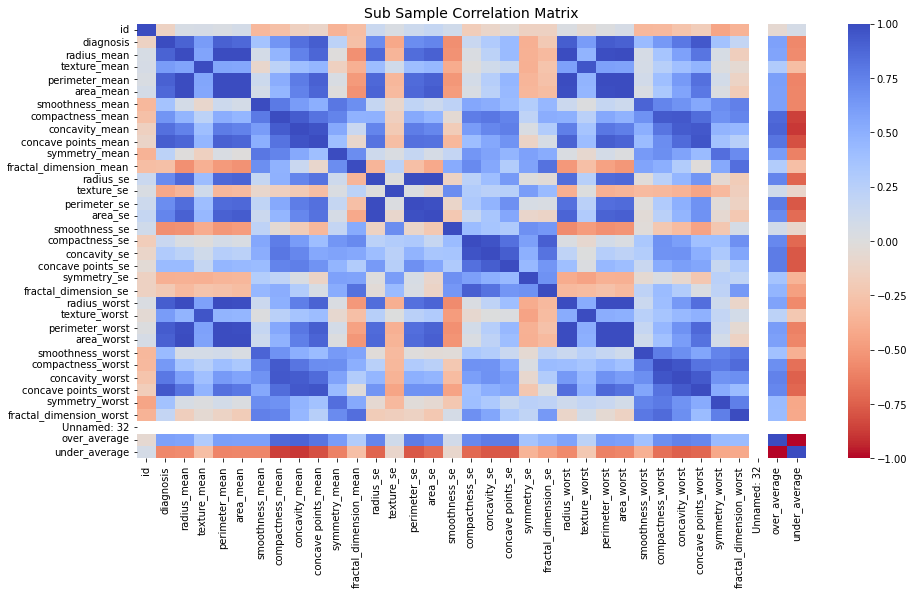

In [12]:
sub_sample_corr = sub_sample_df.corr()
plot_correlation_matrix(sub_sample_corr, "Sub Sample Correlation Matrix")

In [13]:
for col in df:
    if col not in ["id","diagnosis" ]:
        df[col]=df[col]/df[col].max()
df.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,over_average,under_average
count,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,0.0,500.000000,500.000000
mean,3.263049e+07,0.390000,0.506019,0.485904,0.491282,0.265032,0.663292,0.300949,0.210733,0.245754,...,0.210626,0.592867,0.242273,0.220783,0.398557,0.440211,0.403749,NaN,0.062500,0.958333
std,1.326933e+08,0.488238,0.123686,0.106030,0.127233,0.139687,0.094446,0.153722,0.188047,0.193216,...,0.134244,0.102153,0.150423,0.166943,0.226448,0.095459,0.087266,NaN,0.140564,0.093709
min,8.670000e+03,0.000000,0.248346,0.247200,0.232308,0.057377,0.431997,0.056109,0.000000,0.000000,...,0.043535,0.319721,0.025794,0.000000,0.000000,0.235764,0.265253,NaN,0.000000,0.333333
25%,8.667040e+05,0.000000,0.420046,0.409114,0.403156,0.172151,0.594281,0.184199,0.067678,0.100621,...,0.122849,0.522013,0.137925,0.091434,0.217534,0.379180,0.343470,NaN,0.000000,0.966667
50%,9.014320e+05,0.000000,0.477944,0.475560,0.460133,0.222371,0.662232,0.264273,0.150691,0.168340,...,0.162612,0.589623,0.203072,0.184824,0.345876,0.426484,0.385060,NaN,0.000000,1.000000
75%,8.910808e+06,1.000000,0.573284,0.548943,0.563528,0.320182,0.726330,0.377823,0.309630,0.372403,...,0.270510,0.655885,0.324693,0.311062,0.573368,0.482148,0.443687,NaN,0.050000,1.000000
max,9.113205e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000


In [14]:
def find_strongest_correlations(dataframe, qubits):
        
    class_correlations = dataframe.loc['diagnosis', :]
    class_correlations = class_correlations.drop(index = 'diagnosis')
    
    feature_list = list(class_correlations.index)
    correlation_list = [class_correlations[x] for x in feature_list]
    
    features = []
    correlations = []
    
    for i in range(int(qubits/2)):
        
        
        correlations.append(max(correlation_list))
        features.append(feature_list[correlation_list.index(max(correlation_list))])
        
        del feature_list[correlation_list.index(max(correlation_list))]
        del correlation_list[correlation_list.index(max(correlation_list))]                        
                                      
        correlations.append(min(correlation_list))
        features.append(feature_list[correlation_list.index(min(correlation_list))])
        
        del feature_list[correlation_list.index(min(correlation_list))]
        del correlation_list[correlation_list.index(min(correlation_list))] 
    
    return features, correlations
    
    
print(find_strongest_correlations(sub_sample_corr, 32))

(['concave points_worst', 'under_average', 'concave points_mean', 'smoothness_se', 'perimeter_worst', 'symmetry_se', 'radius_worst', 'texture_se', 'perimeter_mean', 'id', 'radius_mean', 'fractal_dimension_mean', 'area_worst', 'fractal_dimension_se', 'concavity_mean', 'compactness_se', 'concavity_worst', 'symmetry_mean', 'area_mean', 'fractal_dimension_worst', 'compactness_mean', 'concavity_se', 'compactness_worst', 'over_average', 'radius_se', 'symmetry_worst', 'perimeter_se', 'smoothness_mean', 'area_se', 'concave points_se', 'texture_worst', 'texture_mean'], [0.7978094945929337, -0.34136937552729707, 0.7586600758878845, -0.04673367527864799, 0.7573614126682594, -0.014679245126787827, 0.7517483793249566, -0.0008038340067537672, 0.7158519439263377, 0.015545914020172781, 0.7034897154332326, 0.01992993695447641, 0.693992457866733, 0.08033080720629472, 0.6879060850990952, 0.2730072852311817, 0.6721760118015622, 0.30982259604589635, 0.6687718080070235, 0.3310101594318854, 0.585579278834709

In [15]:
feature_list, correlations = find_strongest_correlations(sub_sample_corr, 32)

In [16]:
malign=df[df["diagnosis"]==0][feature_list]
malign.head()

,concave points_worst,under_average,concave points_mean,smoothness_se,perimeter_worst,symmetry_se,radius_worst,texture_se,perimeter_mean,id,...,compactness_worst,over_average,radius_se,symmetry_worst,perimeter_se,smoothness_mean,area_se,concave points_se,texture_worst,texture_mean
448,0.329691,1.0,0.145378,0.133216,0.430334,0.176567,0.452275,0.277175,0.500000,911150,...,0.250378,0.0,0.088235,0.372251,0.090719,0.579682,0.042494,0.167608,0.573072,0.492363
137,0.291271,1.0,0.142893,0.164889,0.318193,0.190120,0.341842,0.203439,0.387586,868682,...,0.155766,0.0,0.061225,0.403133,0.052002,0.666137,0.023368,0.162948,0.444489,0.391802
240,0.316907,1.0,0.185437,0.207838,0.374642,0.240405,0.412042,0.135353,0.463554,88350402,...,0.122023,0.0,0.112844,0.381139,0.090810,0.651209,0.050148,0.208941,0.384538,0.397149
362,0.285636,1.0,0.088519,0.180148,0.349602,0.241799,0.381521,0.263050,0.434324,9010598,...,0.173819,0.0,0.077027,0.413378,0.069836,0.668694,0.031833,0.189373,0.524627,0.479633
183,0.216357,1.0,0.117346,0.236299,0.314968,0.274224,0.343230,0.226817,0.390080,873843,...,0.152174,0.0,0.116394,0.272823,0.086533,0.626054,0.041996,0.324304,0.357287,0.379837


In [17]:
benign=df[df["diagnosis"]!=0][feature_list]
benign.head()

,concave points_worst,under_average,concave points_mean,smoothness_se,perimeter_worst,symmetry_se,radius_worst,texture_se,perimeter_mean,id,...,compactness_worst,over_average,radius_se,symmetry_worst,perimeter_se,smoothness_mean,area_se,concave points_se,texture_worst,texture_mean
368,0.625430,0.7,0.420726,0.178863,0.794188,0.159975,0.853219,0.215148,0.747480,9011971,...,0.153875,0.45,0.420118,0.378126,0.351820,0.648514,0.413316,0.226747,0.533710,0.439155
372,0.675601,0.9,0.623757,0.142178,0.605494,0.212160,0.629578,0.267963,0.749602,9012795,...,0.268431,0.15,0.118830,0.411268,0.109509,0.691776,0.072040,0.254404,0.440856,0.384420
94,0.726804,1.0,0.438121,0.297141,0.491640,0.189740,0.505827,0.197421,0.532095,862028,...,0.397259,0.00,0.165959,0.426936,0.168608,0.718037,0.086942,0.350635,0.489100,0.504837
433,0.586942,1.0,0.434592,0.259364,0.578424,0.301837,0.628746,0.395292,0.656233,908445,...,0.327316,0.00,0.285103,0.452998,0.204413,0.703525,0.191627,0.347414,0.624344,0.559318
468,0.685911,0.9,0.498012,0.217347,0.571656,0.211906,0.598502,0.299898,0.631300,9113538,...,0.452268,0.15,0.323321,0.346641,0.263922,0.641949,0.193471,0.437772,0.582761,0.593941


In [18]:
input_data=malign.to_numpy()
input_data

array([[0.32969072, 1.        , 0.14537773, ..., 0.1676075 , 0.57307226,
        0.49236253],
       [0.29127148, 1.        , 0.14289264, ..., 0.16294753, 0.4444893 ,
        0.39180244],
       [0.31690722, 1.        , 0.18543738, ..., 0.20894109, 0.38453775,
        0.39714868],
       ...,
       [0.24010309, 1.        , 0.07321074, ..., 0.10388331, 0.43802987,
        0.43151731],
       [0.41408935, 1.        , 0.1861332 , ..., 0.24493275, 0.61566411,
        0.55498982],
       [0.09608247, 1.        , 0.02779324, ..., 0.07484372, 0.44913201,
        0.4564664 ]])

## Training node

In [19]:
shots = 2500
nr_trash=3
nr_latent=2
nr_ent=0

spec = QubitsArrangement(nr_trash, nr_latent, nr_swap=1, nr_ent=nr_ent)
print("Qubits:", spec.qubits)

#set up the device 
dev = qml.device("default.qubit", wires=spec.num_qubits)

nr_layers = 4

Qubits: [0, 1, 2, 3, 4, 5, 6, 7, 8]


In [20]:
@qml.qnode(dev)
def training_circuit_example(init_params, encoder_params, reinit_state, x):
    # Initialization
    setAB_amplitude(spec, init_params)
    setAux(spec, reinit_state)

    #encoder 
    for params in encoder_params:
        e3_enhance(params, float(x), spec)

    #swap test 
    swap_t(spec)

    return [qml.probs(i) for i in spec.swap_qubits]

## Training parameters 

In [21]:
epochs = 500
learning_rate = 0.0003
batch_size = 5
num_samples = 0.8 # proportion of the data used for training 

beta1 = 0.9
beta2 = 0.999
opt = AdamOptimizer(learning_rate, beta1=beta1, beta2=beta2)

In [22]:
def fid_func(output):
    # Implemented as the Fidelity Loss
    # output[0] because we take the probability that the state after the 
    # SWAP test is ket(0), like the reference state
    fidelity_loss = 1 / output[0]
    return fidelity_loss

In [23]:
def cost(encoder_params, X):
    reinit_state = [0 for i in range(2 ** len(spec.aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output = training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state,x=x[0][1])[0]
        f = fid_func(output)
        loss = loss + f
    return loss / len(X)

In [24]:
def fidelity(encoder_params, X):
    reinit_state = [0 for _ in range(2 ** len(spec.aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output =  training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state,x=x[0][1])[0]
       
        f = output[0]
        loss = loss + f
    return loss / len(X)

In [25]:
def iterate_batches(X, batch_size):
    
    random.shuffle(X)

    batch_list = []
    batch = []
    for x in X:
        if len(batch) < batch_size:
            batch.append(x)

        else:
            batch_list.append(batch)
            batch = []
    if len(batch) != 0:
        batch_list.append(batch)
    return batch_list

In [26]:
training_data = [ torch.tensor([input_data[i]]) for i in range(int(len(input_data)*num_samples))]
test_data = [torch.tensor([input_data[i]]) for i in range(int(len(input_data)*num_samples),len(input_data))]

C:\Users\tomut\AppData\Local\Temp/ipykernel_2132/3998820717.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  training_data = [ torch.tensor([input_data[i]]) for i in range(int(len(input_data)*num_samples))]


In [27]:
batches=iterate_batches(training_data, batch_size)

In [28]:
X_training = training_data
X_tes = test_data

In [29]:
# initialize random encoder parameters
nr_encod_qubits = len(spec.trash_qubits) + len(spec.latent_qubits)
nr_par_encoder = nr_layers * 2 * nr_encod_qubits + 2 * len(spec.trash_qubits)
encoder_params = np.random.uniform(size=(1, nr_par_encoder), requires_grad=True)

###  training

In [30]:
np_benign = benign.to_numpy()
benign_data = [ torch.tensor([np_benign[i]]) for i in range(len(benign.to_numpy()))]

In [34]:
loss_hist=[]
fid_hist=[]

loss_hist_test=[]
fid_hist_test=[]

benign_fid=[]

for epoch in range(epochs):
    batches = iterate_batches(X=training_data, batch_size=batch_size)
    for xbatch in batches:
        encoder_params = opt.step(cost, encoder_params, X=xbatch)

        
    if epoch%5 == 0:
        
        loss_training = cost(encoder_params, X_training )
        fidel = fidelity(encoder_params, X_training )
        
        loss_hist.append(loss_training)
        fid_hist.append(fidel)
        print("Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_training, fidel))

        loss_test = cost(encoder_params, X_tes )
        fidel = fidelity(encoder_params, X_tes )
        loss_hist_test.append(loss_test)
        fid_hist_test.append(fidel)
        print("Test-Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_test, fidel))
        
        b_fidel = fidelity(encoder_params, benign_data )
        benign_fid.append(b_fidel)
        print("malign fid:{}".format(b_fidel))
        
     
        experiment_parameters={"autoencoder":"e2","params":encoder_params}
        f=open("Cancer_encoder_e3-Benign/params"+str(epoch)+".txt","w")
        f.write(str(experiment_parameters))
        f.close()
       

Epoch:0 | Loss:1.548607608476801 | Fidelity:0.6457514409159654
Test-Epoch:0 | Loss:1.548705686726905 | Fidelity:0.6457201305207392
malign fid:0.6405937762986988
Epoch:5 | Loss:1.397456290513533 | Fidelity:0.7156182178173653
Test-Epoch:5 | Loss:1.3974691625620934 | Fidelity:0.7156344810643465
malign fid:0.7066817759727438
Epoch:10 | Loss:1.27457581257031 | Fidelity:0.7846366340683245
Test-Epoch:10 | Loss:1.2745396066443055 | Fidelity:0.7846978878206045
malign fid:0.7721341719224842
Epoch:15 | Loss:1.1867274092591484 | Fidelity:0.8427391447548002
Test-Epoch:15 | Loss:1.1866831015176145 | Fidelity:0.8428234542882312
malign fid:0.8276308804869396
Epoch:20 | Loss:1.1271277114303824 | Fidelity:0.8873072099461734
Test-Epoch:20 | Loss:1.1271019055087372 | Fidelity:0.887388839018193
malign fid:0.8707693817622096
Epoch:25 | Loss:1.0873299790510147 | Fidelity:0.9197781900036319
Test-Epoch:25 | Loss:1.0873371937661127 | Fidelity:0.9198360151455
malign fid:0.9028555551528826
Epoch:30 | Loss:1.06065

malign fid:0.9943370090219686
Epoch:250 | Loss:1.0003964575854414 | Fidelity:0.9996066741982665
Test-Epoch:250 | Loss:1.000577997541341 | Fidelity:0.999433148675507
malign fid:0.9944678791984981
Epoch:255 | Loss:1.0003860440853436 | Fidelity:0.9996170106164317
Test-Epoch:255 | Loss:1.0005627072050884 | Fidelity:0.9994480905769759
malign fid:0.9945418293490748
Epoch:260 | Loss:1.0003768153859873 | Fidelity:0.9996260715687855
Test-Epoch:260 | Loss:1.000549921703099 | Fidelity:0.9994603365582599
malign fid:0.9946633760852687
Epoch:265 | Loss:1.0003667440179371 | Fidelity:0.9996360279452471
Test-Epoch:265 | Loss:1.0005361084649653 | Fidelity:0.999473740888913
malign fid:0.994759541648004
Epoch:270 | Loss:1.0003590792482357 | Fidelity:0.9996436910553451
Test-Epoch:270 | Loss:1.000521686350879 | Fidelity:0.9994879534738607
malign fid:0.9948009554513886
Epoch:275 | Loss:1.0003502797946247 | Fidelity:0.9996523591141392
Test-Epoch:275 | Loss:1.0005085844434165 | Fidelity:0.9995005922574014
mali

Test-Epoch:495 | Loss:1.000199846790313 | Fidelity:0.9998015388318217
malign fid:0.9977533805462357


## Rezults

In [35]:
import matplotlib.pyplot as plt

fidelity: 0.999862411896508


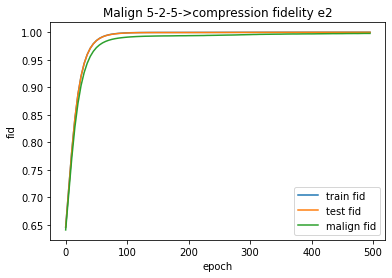

In [36]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist),label="train fid")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist_test),label="test fid")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(benign_fid),label="malign fid")

plt.legend()
plt.title("Malign 5-2-5->compression fidelity e2",)
plt.xlabel("epoch")
plt.ylabel("fid")

print("fidelity:",fid_hist[-1])

loss: 1.0001379761290272


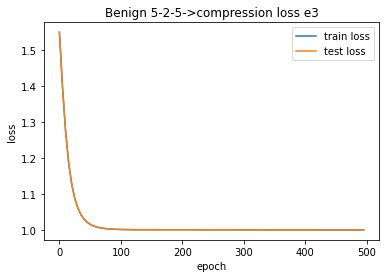

In [37]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist),label="train loss")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist_test),label="test loss")


plt.legend()
plt.title("Benign 5-2-5->compression loss e3",)
plt.xlabel("epoch")
plt.ylabel("loss")

print("loss:",loss_hist[-1])

## Benign performance 

In [39]:
np_benign = benign.to_numpy()
benign_data = [ torch.tensor([np_benign[i]]) for i in range(len(benign.to_numpy()))]

loss = cost(encoder_params, benign_data )
fidel = fidelity(encoder_params, benign_data )

print("Benign results:")
print("fidelity=",fidel)
print("loss=",loss)


C:\Users\tomut\anaconda3\envs\qhack2022\lib\site-packages\pennylane\math\multi_dispatch.py:63: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Benign results:
fidelity= 0.9978006253751093
loss= 1.0022568318476286


## Classifyer

In [40]:
beningn_flist=[]
for b in benign_data:
    f=fidelity(encoder_params, [b])
    beningn_flist.append(f.item())
    
print(min(beningn_flist))
print(max(beningn_flist))

0.9376149840178007
0.9999842161014373


In [41]:
malign_flist=[]
for b in training_data:
    f=fidelity(encoder_params, [b])
    malign_flist.append(f.item())
    
print(min(malign_flist))
print(max(malign_flist))

0.9931552833866646
0.9999841932229643


In [42]:
beningn_flist

[0.9931553022456596,
 0.9993938989226918,
 0.9999838838224732,
 0.9999838843949691,
 0.9993938994330157,
 0.9993938990457665,
 0.9911390712783258,
 0.9931551928068075,
 0.9999839274195267,
 0.9997615778931382,
 0.9999838843487876,
 0.9999838805214745,
 0.9999838847642236,
 0.9999838846443325,
 0.9999838805652936,
 0.9999838805794086,
 0.999983883648665,
 0.9993938833569789,
 0.9999838801717458,
 0.9997615917481915,
 0.9999629582238141,
 0.9999838805830137,
 0.9823217541189777,
 0.9999838836764341,
 0.9999838837121146,
 0.9972761812659946,
 0.9999629850073734,
 0.9999838840178333,
 0.999983880179785,
 0.9999838846444281,
 0.9999839241595527,
 0.9999838839269176,
 0.9999838842321342,
 0.9999838801822334,
 0.9999838831154833,
 0.9999629802138565,
 0.9823218125130145,
 0.9999838835796155,
 0.9999838805655671,
 0.9988636362080517,
 0.9993938751148187,
 0.9999629817189414,
 0.9981636724798394,
 0.9997615822638878,
 0.9999842161014373,
 0.9999838801787528,
 0.999983880179649,
 0.9911391631479

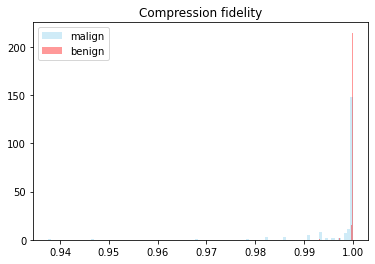

In [43]:
plt.hist(beningn_flist, bins = 100 ,label="malign", color = "skyblue",alpha=0.4)
plt.hist(malign_flist, bins =100 ,label="benign",color = "red",alpha=0.4)
plt.title("Compression fidelity",)
plt.legend()
plt.show()

In [58]:
split=0.9989


print("split:",split)
b_e=[]
for i in beningn_flist:
    if i<split:
        b_e.append(1)
    else:
        b_e.append(0)
ab_ac=sum(b_e)/len(b_e)
print("malign classification accuracy:",ab_ac)
m_e=[]
for i in malign_flist:
    if i>split:
        m_e.append(1)
    else:
        m_e.append(0)
am_ac=sum(m_e)/len(m_e)
print("benign classification accuracy:",am_ac)
t_ac=(sum(b_e)+sum(m_e))/(len(b_e)+len(m_e))
print("total accuracy:",t_ac)

split: 0.9989
malign classification accuracy: 0.24102564102564103
benign classification accuracy: 0.9631147540983607
total accuracy: 0.642369020501139
